In [1]:
# quick peek for blending performance
import src.utilities as utils

import numpy as np
import torch
from pathlib import Path
from src.models.camerbert import Camembert
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import (accuracy_score, f1_score, matthews_corrcoef,
                             precision_score, recall_score, roc_auc_score)

configs = utils.read_config()
root = utils.get_project_root()

data_path = str(Path.joinpath(root, configs['data']['wangcha_tt']))

# model_path = str(Path.joinpath(root, configs['wangchan_models']['tt']))
# model = Camembert(3)
# model.load_state_dict(torch.load(model_path + "\\" + "model_5.pt"))
# model.to('cuda')

# 
# training = load_svmlight_file(data_path + "\\" + "traindata_0.scl")
# testing = load_svmlight_file(data_path + "\\" + "testdata_0.scl")


# 0,0.7811704834605598,0.7719286558644697,0.7820570802069415,0.6593464463845761,0.908612481584267,0.7769598609825261,0,0.7760814249363868,0.7692410274514524,0.774927977335592,0.6502679211201797,0.8980011916042151,0.7720740302888224
# 1,0.7735368956743003,0.7701945808328787,0.764833658820708,0.6414001135632532,0.89648447939151,0.7675047586033062,1,0.7582697201017812,0.7508950031034137,0.7476393520626443,0.617648678138281,0.8793021321716731,0.7492636410395849
# 2,0.7633587786259542,0.7576760404346611,0.7873334018569911,0.648466587326923,0.9158640833247679,0.7722200759318687,2,0.7913486005089059,0.7796474478506252,0.8028301796498885,0.6810863332764473,0.9137986640086303,0.7910690043816008
# 3,0.7659033078880407,0.7568697598876257,0.7865351012437044,0.6480003450856164,0.9048328022749854,0.7714173360645608,3,0.7455470737913485,0.7404526114907904,0.7731323671973168,0.6228960341757012,0.90760085223971,0.7564396956628016
# 4,0.8091603053435115,0.8007530201929937,0.7999503203481001,0.6986191009463396,0.9100527632165005,0.8003514690068196,4,0.7811704834605598,0.7731898031250782,0.7834896843855411,0.6577737846325574,0.9143417395097128,0.778305668804483
# 5,0.7379134860050891,0.7275283797729619,0.7540103470723266,0.6024059060608509,0.8884443416589578,0.7405326856432055,5,0.72264631043257,0.7154834290432759,0.7362158806727677,0.5761845995406323,0.8725510755885896,0.7257016095473667
# 6,0.7480916030534351,0.7337196879348041,0.7541765169424745,0.6153181899551015,0.8888429780381677,0.7438074737268793,6,0.7608142493638677,0.7542837007953286,0.7844249193633294,0.6434787367887367,0.8860013167124029,0.7690590972479775
# 7,0.7531806615776081,0.7392251374809514,0.7553157227532806,0.6175652256740024,0.9025121629492583,0.7471838125674407,7,0.8193384223918575,0.8081886829459646,0.8203589989704212,0.7181193871410597,0.926660281363529,0.8142283659027862
# 8,0.806615776081425,0.8048494800218938,0.7898139582690925,0.6927561380311564,0.9141369445300991,0.7972608368173006,8,0.732824427480916,0.732843642507508,0.7331192821114434,0.5818007488656639,0.8682102316620792,0.7329814363957264
# 9,0.7404580152671756,0.7270342392906111,0.7414636653304553,0.5969337020523933,0.9075209853701991,0.7341780607092636,9,0.7786259541984732,0.7699214975845411,0.8015247474933925,0.6696178018568231,0.9157241678938207,0.7854053371206206

In [2]:
def get_data(idx):
    data = load_svmlight_file(data_path + "\\" + "traindata_"+str(idx)+".scl", zero_based=False)
    data1 = load_svmlight_file(data_path + "\\" + "testdata_"+str(idx)+".scl", zero_based=False)
    return data[0].toarray(), data[1], data1[0].toarray(), data1[1]

In [3]:
# def test(models, blender, y_test, p, pr):
#     ACC = accuracy_score(y_test, p)
#     SENS = precision_score(y_test, p, average='macro')
#     SPEC = recall_score(y_test,p, average='macro')
#     MCC = matthews_corrcoef(y_test,p)
#     AUC = roc_auc_score(y_test, pr, multi_class='ovo',average='macro')
#     #AUC = roc_auc_score(test_y,pr[:,1]) # for binary classification problem
#     F1 = 2*SENS*SPEC/(SENS+SPEC)
#     print("ACC:", ACC, ", MCC:" , MCC, " ,F1:", F1)

In [4]:
Xo, yo, Xt, yt = get_data(4)

# Check each classifier performance.

In [5]:
# from sklearn.metrics import accuracy_score
# from sklearn.svm import SVC
# svc = SVC()
# svc.fit(Xo, yo)
# y_pred = svc.predict(Xt)
# print(accuracy_score(yt, y_pred))


In [6]:
# from lightgbm import LGBMClassifier
# lgbm = LGBMClassifier()
# lgbm.fit(Xo, yo)
# y_pred = lgbm.predict(Xt)
# print(accuracy_score(yt, y_pred))

In [7]:
# from sklearn.naive_bayes import GaussianNB
# nb = GaussianNB()
# nb.fit(Xo, yo)
# y_pred = nb.predict(Xt)
# print(accuracy_score(yt, y_pred))

In [8]:
# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# xgb.fit(Xo, yo)
# y_pred = xgb.predict(Xt)
# print(accuracy_score(yt, y_pred))

In [9]:
# from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
# et = ExtraTreesClassifier()
# et.fit(Xo, yo)
# y_pred = et.predict(Xt)
# print(accuracy_score(yt, y_pred))

# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# y_pred = rf.predict(Xt)
# print(accuracy_score(yt, y_pred))

In [10]:
X_train, X_val, y_train, y_val = train_test_split(Xo, yo, test_size=0.2, random_state=0, stratify=yo)    

In [11]:
# from sklearn.linear_model import LogisticRegression
# # use default parem to avoid overfitting?
# def get_models():
#     models = list()
#     models.append(('SVM', SVC()))
#     models.append(('LGBM', LGBMClassifier()))
#     models.append(('RF', RandomForestClassifier()))
#     models.append(('ET', ExtraTreesClassifier()))
#     models.append(('NB', GaussianNB()))
#     return models

In [12]:
# def fit_ensemble(models, X_train, X_val, y_train, y_val):
#     meta = list()
#     for _, model in models:
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         y_pred = y_pred.reshape(len(y_pred), 1)
#         meta.append(y_pred)
        
#     meta = np.hstack(meta)
#     blender = LogisticRegression()
#     blender.fit(meta, y_val)
#     return blender

In [13]:
# #FIXME: get the validate accuracy out.
# def predict_ensemble(models, blender, X_test):
#     meta = list()
#     for _, model in models:
#         y_pred = model.predict(X_test)
#         y_pred = y_pred.reshape(len(y_pred), 1)
#         meta.append(y_pred)
        
#     meta = np.hstack(meta)
#     return blender.predict(meta)
    
# def predict_proba_ensemble(models, blender, X_test):
#     meta = list()
#     for _, model in models:
#         y_pred = model.predict(X_test)
#         y_pred = y_pred.reshape(len(y_pred), 1)
#         meta.append(y_pred)
        
#     meta = np.hstack(meta)
#     return blender.predict_proba(meta)

In [14]:
# models = get_models()
# blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# p = predict_ensemble(models, blender, Xt)
# pr = predict_proba_ensemble(models, blender, Xt)

In [15]:
# # TODO: performance is random for each run a bit here, we can do something with resample? or some ..random weight?
# test(models, blender, yt, p, pr)

c:\Users\Pree\anaconda3\envs\sciGPU\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


test_acc. 0.7735368956743003
>lr val_acc. 0.881 (0.029)
test_acc. 0.7709923664122137
>knn val_acc. 0.874 (0.031)
test_acc. 0.7633587786259542
>rf val_acc. 0.872 (0.029)
test_acc. 0.7760814249363868
>svm val_acc. 0.881 (0.029)
test_acc. 0.7709923664122137
>bayes val_acc. 0.876 (0.030)


c:\Users\Pree\anaconda3\envs\sciGPU\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Pree\anaconda3\envs\sciGPU\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

test_acc. 0.7760814249363868
>blending val_acc. 0.878 (0.031)


c:\Users\Pree\anaconda3\envs\sciGPU\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


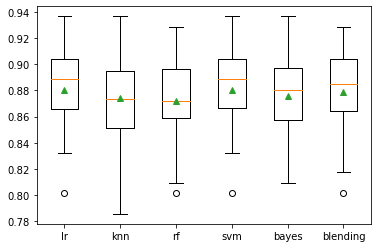

In [20]:
# try sklearn library
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
 

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('rf', RandomForestClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=2)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['rf'] = RandomForestClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['blending'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	model.fit(X, y)
	y_pred = model.predict(Xt)
	print("test_acc.", accuracy_score(yt, y_pred))
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s val_acc. %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [21]:
# test with unseen